In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade keras
!pip install ipympl
!pip install formulaic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import cm
from formulaic import Formula
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from time import time

Instalar las siguientes librerias y reiniciar el kernel

Para Windows (descomentar y ejecutar):

In [ ]:
#%matplotlib notebook

Para Linux (decomentar y ejecutar):

In [2]:
%matplotlib widget

# Descenso Por Gradiente

### Laboratorio de Datos, IC - FCEN - UBA - 1er. Cuatrimestre 2024

Importamos el Regresor basado en Tensorflow y Keras. Ya viene implementado con Descenso por Gradiente y Descenso por
Gradiente Estocástico. Sirve para hacer Regresión (Lineal y no Lineal) y para clasificación con Regresión Logística.

También importamos la función ``train_test_split_scale_center`` que separa los datos en entrenamiento y testeo, aplica ``MinMaxScaler`` y, opcionalmente, los
centra.

In [3]:
from tf_regressor import Regressor, train_test_split_scale_center

### Motivación 1

Resolver sistemas de ecuaciones *grandes* es computacionalmente costoso. Veamos un ejemplo, con un dataset sintético
de $11000$ observaciones de $10000$ features cada una (un total de $110$ millones de valores).

Utilizamos el modelo:
$$Y = \beta_0 + \sum_{i=1}^{10000} \beta_iX_i$$

In [4]:
# Generamos 11000 muestras aleatorias con 10000 features cada una
np.random.seed(11)
n, m = 11000, 10000
mega_X = np.random.randn(n, m)
simulation_weights = np.random.randint(3, size=mega_X.shape[1])
mega_Y = (mega_X @ simulation_weights + np.random.randn(int(n)) / 10).reshape(-1, 1) # reshape para volverlo una columna

# Normalizamos los datos y los centramos
mega_X_train, mega_X_test, mega_y_train, mega_y_test = train_test_split_scale_center(mega_X, mega_Y,
                                                                                     transform_y=True,
                                                                                     test_size=0.2,
                                                                                     random_state=21)

<font color='red'>**CUIDADO AL CORRER ESTO, PUEDE EXPLOTAR**<font>

In [ ]:
# Hacemos regresion lineal con scikit-learn
model = linear_model.LinearRegression()
start = time()  # marcamos el tiempo de inicio del entrenamiento
model.fit(mega_X_train, mega_y_train)
tiempo_matricial = time() - start   # registramos el tiempo total de entrenamiento
mse_matricial = mean_squared_error(mega_y_test, model.predict(mega_X_test))
print('Tiempo total de entrenamiento: ', tiempo_matricial)
print('MSE en conjunto de testeo: ', mse_matricial)

Tiempo total de entrenamiento:  495.2040684223175
MSE en conjunto de testeo:  0.002125081488828869


### Motivación 2

Tenemos un dataset con la evolución de nuevos casos diarios de COVID

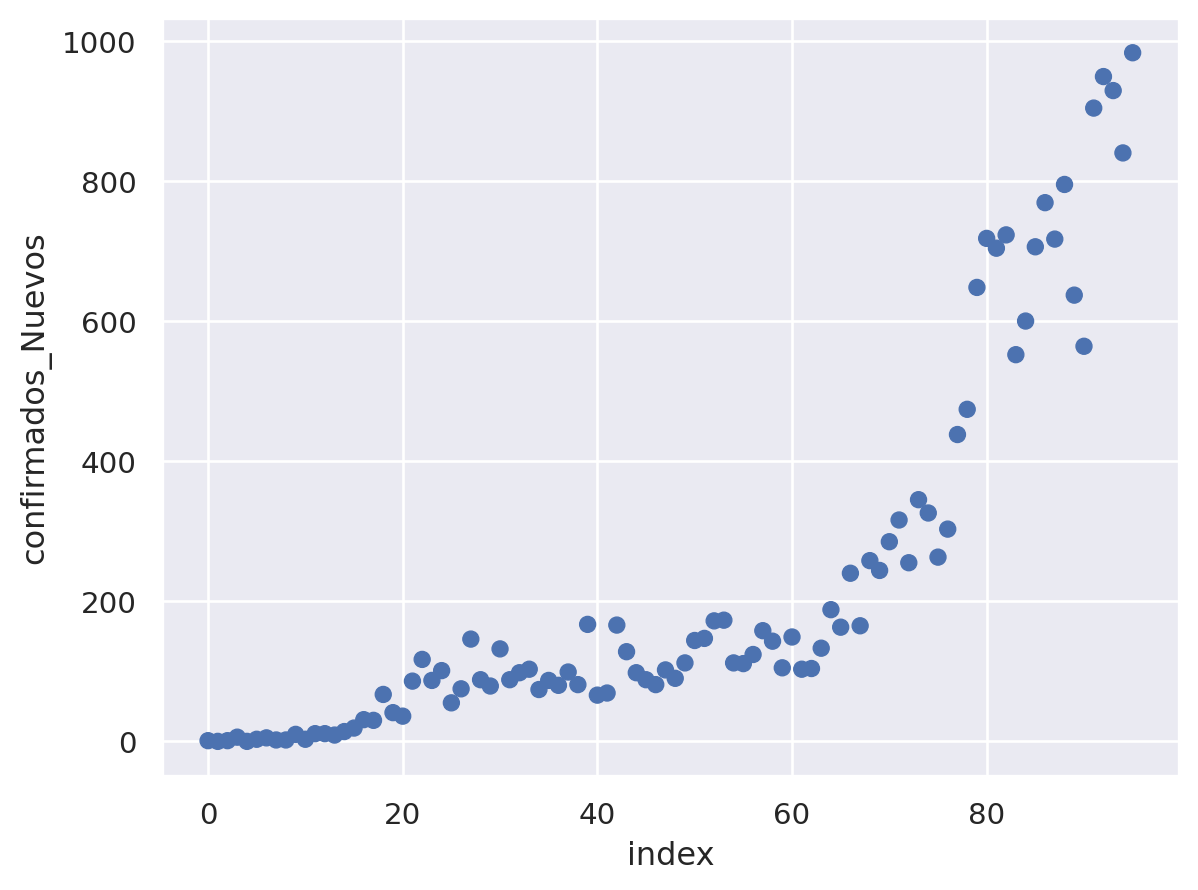

In [5]:
coro = pd.read_csv('casos_coronavirus.csv')
coro.reset_index(inplace=True)      # Reseteamos el índice para trabajar con los indices en vez de las fechas
so.Plot(data=coro, x='index', y='confirmados_Nuevos').add(so.Dot())

¿Qué tipo de función parece que sigue la evolución de los casos? ¿Podemos plantear un modelo de regresión **lineal**?

### 1. Ejemplo: Regresión Lineal con una variable predictora

Usemos el dataset de ``inmuebles.csv`` para hacer regresión lineal del precio a partir de la superficie del inmueble:
$$precio = b + w\cdot superficie \qquad (precio \sim superficie) $$

In [6]:
# Cargamos el dataset
data = pd.read_csv('inmuebles.csv')

# Normalizamos los datos
X = data['superficie']
y = data['precio']
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y,
                                                                 transform_y=True,  # Normalizamos y también
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=11)   # Semilla para datos de testeo

In [7]:
# Definimos la funcion del modelo (x, w, b deben respetar ese orden en la declaracion de lambda)
f = lambda x, w, b: b + w*x

In [8]:
# Inicializamos el modelo (por ahora no tiene nada)
model = Regressor()

# Le agregamos la funcion y especificamos la dimension de w
model.add_f(f,                  # funcion del modelo
            dim_w=1,            # dimension de w
            random_state=21,    # semilla para selecciones aleatorias
            opt='gd'            # Especificamos que usamos descenso por gradiente
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model.fit_(X_train, y_train,        # Conjuntos de entrenamiento
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.05)      # Learning rate inicial


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1794 - val_loss: 0.1204
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.1551 - val_loss: 0.1056
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1361 - val_loss: 0.0946
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.1214 - val_loss: 0.0863
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.1098 - val_loss: 0.0802
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.1008 - val_loss: 0.0757
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - loss: 0.0937 - val_loss: 0.0723
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0880 - val_loss: 0.0699
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0835 - val_loss: 0.0681
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0799 - val_loss: 0.0668
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0770 - val_loss: 0.0658
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0746

In [9]:
# Imprimimos los pesos y el bias resultantes del entrenamiento
print(model.weights_)
print(model.bias_)

[0.49017894]
0.14221373


In [10]:
# Evaluamos el MSE en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'loss': 0.021921295672655106}

In [ ]:
# Podemos graficar la evolución de la función de pérdida (MSE)
model.plot_loss()

In [ ]:
# Podemos graficar como evolucionó el algoritmo a través de las épocas
model.plot_path()

In [ ]:
# Y ver una animación de cómo fue evolucionando la regresión
model.animate_regression(X_train, y_train)

**Obs:** el desempeño y el resultado del algoritmo dependen de la elección de pesos y bias inciales

In [ ]:
model2 = Regressor()

# Volvamos a entrenar el modelo proporcionándole pesos y bias iniciales
model2.add_f(f,                 # funcion del modelo
            w0=1,               # peso inicial
            b0=0,               # bias inicial
            opt='gd',           # Especificamos que usamos descenso por gradiente
            random_state=21,    # semilla para selecciones aleatorias
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model2.fit_(X_train, y_train,       # Conjuntos de entrenamiento
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.05)      # Learning rate inicial

In [ ]:
# Evaluamos el MSE en el conjunto de testeo
model2.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas
               return_dict=True,                             # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                    # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

In [ ]:
model2.plot_loss()

In [ ]:
model2.animate_regression(X_train, y_train)

### 2. Ejemplo: Regresión Lineal con más de una variable predictora

Vamos a tratar de predecir el peso de los pingüinos según la longitud de su pico y la de su aleta, y su interacción:
$$body\_mass\_g = b + w_0\cdot bill\_length\_mm + w_1\cdot flipper\_length\_mm +
w_2\cdot bill\_length\_mm\cdot flipper\_length\_mm$$
o, escrito con la notación de Wilkinson-Rogers:
$$body\_mass\_g \sim bill\_length\_mm*flipper\_length\_mm$$

In [ ]:
# Cargamos el dataset
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace=True)

# Elegimos los features, separamos en entrenamiento y testeo y normalizamos
X = penguins[['bill_length_mm', 'flipper_length_mm']]
y = penguins['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y,
                                                                 transform_y=True,  # Normalizamos y también
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=11)   # Semilla para datos de testeo

# Definimos la funcion del modelo
f = lambda x, w, b: b + w[0]*x[:,0] + w[1]*x[:,1] + w[2]*x[:,0]*x[:,1]

model3 = Regressor()

# Volvamos a entrenar el modelo con pesos y bias iniciales aleatorios
model3.add_f(f,                 # funcion del modelo
            dim_w= 3,           # dimension de w
            random_state=2077,  # semilla para selecciones aleatorias
            opt='gd'            # Especificamos que usamos descenso por gradiente
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model3.fit_(X_train, y_train,       # Conjuntos de entrenamiento
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.05)      # Learning rate inicial

In [ ]:
# Imprimimos pesos y bias obtenidos con el entrenamiento
print(model3.weights_)
print(model3.bias_)

In [ ]:
# Calculamos el MSE en el conjunto de testeo
model3.evaluate(X_test.to_numpy(), y_test.to_numpy(),         # A TensorFlow no le gustan los DataFrame de pandas
                return_dict=True,                             # Devuelve un diccionario (por si usamos mas de una métrica)
                verbose=0,                                    # No imprima en pantalla el procedimiento de evaluación
                batch_size=len(y_test))

In [ ]:
# Graficamos la evolución del MSE
model3.plot_loss()

### 3. Ejemplo: Regresión no lineal

Vamos a realizar Regresión Logística para clasificar pingüinos según su especie (Gentoo o Chinstrap) a partir de su
peso.

In [ ]:
# Nos quedamos solo con los pingüinos Gentoo o Chinstrap
penguins_clasif = penguins[penguins['species'].isin(['Chinstrap', 'Gentoo'])]

X = penguins_clasif['body_mass_g']
y = penguins_clasif['species']

# Transformamos y a un vector de 1's y 0's:
y = y.apply(lambda t: 1*(t == 'Gentoo'))

In [ ]:
# Graficamos los pesos según la especie
(
    so.Plot()
    .add(so.Dot(), x=X, y=y.iloc[::-1], color=penguins_clasif['species'])
)

In [ ]:
# separamos en entrenamiento y testeo, normalizamos y centramos
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y,
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=10)   # Semilla para datos de testeo

# Definimos la funcion del modelo
f = lambda x, w, b: 1 / (1 + np.e**(-(b + w*x)))

model4 = Regressor()

# Entrenamos el modelo proporcionándole pesos y bias iniciales
model4.add_f(f,                  # funcion del modelo
            w0 = 0,              # peso incial
            b0 = 0,              # bias inicial
            random_state=21,     # semilla para selecciones aleatorias
            opt='gd'             # Especificamos que usamos descenso por gradiente
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model4.fit_(X_train, y_train,        # Conjuntos de entrenamiento
            classify=True,           # Indicamos que vamos a clasificar
            epochs=50,               # Cantidad de epocas
            validation_split=0.2,    # 20% de datos para validacion
            learning_rate=0.5)       # Learning rate inicial

In [ ]:
# Imprimimos pesos y bias obtenidos con el entrenamiento
print(model4.weights_)
print(model4.bias_)

In [ ]:
# Calculamos el BCE en el conjunto de testeo
model4.evaluate(X_test.to_numpy(), y_test.to_numpy(),       # A TensorFlow no le gustan los DataFrame de pandas
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

In [ ]:
# Graficamos la evolución del BCE
model4.plot_loss()

In [ ]:
# Calculamos la prediccion del modelo para X_test
y_pred = (model4.predict(X_test, verbose=0, batch_size=len(y_test)).flatten() > 0.5).astype('int')
y_pred

In [ ]:
# Graficamos la clasificación
(
    so.Plot(x=X_test, y=y_test, color=y_pred)
    .add(so.Dot())
    .label(color='Clasificacion')
    .scale(color={1: 'red', 0:'black'})
)

In [ ]:
# Animamos la regresion resultante en cada época
model4.animate_regression(X_train, y_train)

### 4. Ejemplo: Descenso por Gradiente Estocástico

Rehacemos la clasificación anterior, pero usando SGD

In [ ]:
# Definimos la funcion del modelo
f = lambda x, w, b: 1 / (1 + np.e**(-(b + w*x)))

model5 = Regressor()

# Volvamos a entrenar el modelo, pero con SGD
model5.add_f(f,                  # funcion del modelo
            w0 = 0,              # peso incial
            b0 = 0,              # bias inicial
            random_state=21,     # semilla para selecciones aleatorias
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model5.fit_(X_train, y_train,       # Conjuntos de entrenamiento
            classify=True,          # Indicamos que vamos a clasificar
            epochs=50,              # Cantidad de epocas
            batch_size=1,           # tamaño del batch
            validation_split=0.2,   # 20% de datos para validacion
            learning_rate=0.5)      # Learning rate inicial

In [ ]:
# Calculamos el BCE en el conjunto de testeo
model5.evaluate(X_test.to_numpy(), y_test.to_numpy(),       # A TensorFlow no le gustan los DataFrame de pandas
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

In [ ]:
# Comparado con el modelo de Descenso por Gradiente
model4.evaluate(X_test.to_numpy(), y_test.to_numpy(),       # A TensorFlow no le gustan los DataFrame de pandas
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

In [ ]:
# Graficamos la evolución del BCE
model5.plot_loss()

In [ ]:
# Calculamos la prediccion del modelo para X_test y graficamos la clasificacion
y_pred = (model5.predict(X_test, verbose=0, batch_size=len(y_test)).flatten() > 0.5).astype('int')
(
    so.Plot(x=X_test, y=y_test, color=y_pred)
    .add(so.Dot())
    .label(color='Clasificacion')
    .scale(color={1: 'red', 0:'black'})
)

In [ ]:
# Animamos la regresion resultante en cada época
model5.animate_regression(X_train, y_train)

### 5. Extras

#### 5.1 Learning Rate Schedule

In [ ]:
# Volvemos a trabajar con el dataset de pinguinos
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace=True)

# Elegimos los features, separamos en entrenamiento y testeo y normalizamos
X = penguins[['bill_length_mm', 'flipper_length_mm']]
y = penguins['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y,
                                                                 transform_y=True,  # Normalizamos y también
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=10)   # Semilla para datos de testeo

# Definimos la funcion del modelo
f = lambda x, w, b: b + w[0]*x[:,0] + w[1]*x[:,1] + w[2]*x[:,0]*x[:,1]

In [ ]:
# Consideramos el modelo con learning rate constante 0.05
model_no_schedule = Regressor()

# Inicializamos el modelo con pesos y bias iniciales aleatorios
model_no_schedule.add_f(f,                  # funcion del modelo
                        dim_w= 3,           # dimension de w
                        random_state=2077,  # semilla para selecciones aleatorias
                        )

# Entrenamos el modelo con los conjuntos de entrenamiento
model_no_schedule.fit_(X_train, y_train,        # Conjuntos de entrenamiento
                       epochs=200,              # Cantidad de epocas
                       validation_split=0.2,    # 20% de datos para validacion
                       batch_size = 6,
                       verbose=0
                       )

# Calculamos el error en el conjunto de testeo
model_no_schedule.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas
                           return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
                           verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
                           batch_size=len(y_test))

In [ ]:
# Lo mismo pero con learning rate variable
model_with_schedule = Regressor()

# Definimos una funcion que disminuya el learning rate a medida que aumentan las epocas
def schedule(epoch, learning_rate):
    if epoch <= 10:
        return learning_rate
    else:
        return learning_rate * (0.95 ** ((epoch + 1) % 10 == 0))


# Inicializamos el modelo con pesos y bias iniciales aleatorios
model_with_schedule.add_f(f,                  # funcion del modelo
                          dim_w= 3,           # dimension de w
                          random_state=2077,  # semilla para selecciones aleatorias
                          )

# Entrenamos el modelo con los conjuntos de entrenamiento
model_with_schedule.fit_(X_train, y_train,        # Conjuntos de entrenamiento
                         epochs=200,              # Cantidad de epocas
                         validation_split=0.2,    # 20% de datos para validacion
                         learning_rate=0.1,       # Learning rate inicial
                         lr_scheduler=schedule,   # Agregamos la funcion de schedule
                         batch_size = 6,
                         )

# Calculamos el error en el conjunto de testeo
model_with_schedule.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas
                             return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
                             verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
                             batch_size=len(y_test)
                             )

#### 5.2 Early Stopping

In [ ]:
# Agregamos ahora early stopping para que el entrenamiento pare si el MSE no mejora en varias epocas
model_with_schedule_and_es = Regressor()

# Inicializamos el modelo con pesos y bias iniciales aleatorios
model_with_schedule_and_es.add_f(f,      # funcion del modelo
                                 dim_w= 3,           # dimension de w
                                 random_state=2077,  # semilla para selecciones aleatorias
                                 )

# Entrenamos el modelo con los conjuntos de entrenamiento
model_with_schedule_and_es.fit_(X_train, y_train,        # Conjuntos de entrenamiento
                                epochs=200,              # Cantidad de epocas
                                validation_split=0.2,    # 20% de datos para validacion
                                learning_rate=0.1,       # Learning rate inicial
                                lr_scheduler=schedule,   # Agregamos la funcion de schedule
                                batch_size = 6,
                                early_stopping=True,     # Activamos el early stopping
                                start_from_epoch=50,     # Entra en funcionamiento a partir de la epoca 50
                                patience=30,             # Si en 30 epocas el MSE no mejora, para
            )

# Calculamos el error en el conjunto de testeo
model_with_schedule_and_es.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas
                                    return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
                                    verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
                                    batch_size=len(y_test)
                                    )

### 6. Comparación con resolución matricial

In [ ]:
import tensorflow as tf

# Ahora con SGD
model = Regressor()
# f = lambda x, w, b: b + sum(w[i] * x[:, i] for i in range(len(w)))
f = lambda x, w, b: b + tf.linalg.matvec(x,w)
model.add_f(f,
            w0=np.zeros(mega_X_train.shape[1]),
            b0=0,
            random_state=21
           )

start = time()
model.fit_(mega_X_train, mega_y_train,
           batch_size=100,
           epochs=200,             # Cantidad de epocas
           verbose=0,              # No imprime progreso
           clipnorm=2,             # Normaliza el gradiente
           validation_split=0.2)   # 20% de datos para validacion)

tiempo_SGD = time() - start
print('Tiempo total de entrenamiento: ', tiempo_SGD)

loss_dict = model.evaluate(mega_X_test.to_numpy(), mega_y_test.to_numpy(),   # A TensorFlow no le gustan los DataFrame de pandas
                           return_dict=True,                                 # Devuelve un diccionario (por si usamos mas de una métrica)
                           verbose=0,                                        # No imprima en pantalla el procedimiento de evaluación
                           batch_size=len(mega_y_test))
mse_SGD = loss_dict['loss']
print('MSE en conjunto de testeo: ', mse_SGD)

In [ ]:
print('Tiempo total de entrenamiento: ', tiempo_matricial)
print('MSE en conjunto de testeo: ', mse_matricial)

In [ ]:
print(f'En {100*(tiempo_SGD / tiempo_matricial):.2f}% de tiempo, SGD obtuvo una solucion con {100*(mse_SGD / mse_matricial-1):.2f}% mas error cuadratico medio')

### 7. Incluyendo `formulaic`

A veces podríamos querer usar `formulaic` para modelos **lineales** más complejos. Como ejemplo, supongamos que queremos aproximar el precio de un inmueble con un modelo de la forma:
$$precio = b + w_1e^{superficie} + w_2\,zona$$

Para esto nos vendría bien usar `formulaic`

In [ ]:
# Cargamos el dataset
data = pd.read_csv('inmuebles.csv')

# Transformamos los datos segun la formula (le dejamos el intercept a LinearRegression o a Regressor)
y, X = Formula('precio~np.exp(superficie)+zona-1').get_model_matrix(data)

# Normalizamos los datos (no los centramos para no alterar las variables dummy) y dividimos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y,
                                                                 transform_y=True,  # Normalizamos y también
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=11)   # Semilla para datos de testeo

#### 7.1 Con `LinearRegression` de `scikit-learn`

In [ ]:
# Hacemos la regresion con los datos transformados
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Calculamos el error cuadratico medio
mean_squared_error(y_test, model.predict(X_test))

#### 7.2 Con `Regressor` de `tf_regressor`

In [ ]:
# Escribimos la funcion del modelo, teniendo en cuenta a que corresponde cada columna de X_train:
# Columna 0: e^superficie
# Columnas 1 a 3: variables dummy para 'zona'
f = lambda x, w, b: b + w[0]*x[:,0] + w[1]*x[:,1] + w[2]*x[:,2] + w[3]*x[:,3]

model = Regressor()

model.add_f(f,                  # funcion del modelo
            w0=np.zeros(4),     # Vector inicial de 0's de longitud 4
            b0=0,
            random_state=21,
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model.fit_(X_train, y_train,
           epochs=200,
           validation_split=0.2,
           learning_rate=0.05,
           batch_size=5,
           verbose=0)

model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               return_dict=True,
               verbose=0,
               batch_size=len(y_test))